In [3]:
import numpy as np
import scipy.integrate as integrate
from scipy.optimize import fsolve, curve_fit
from sympy import log
from math import exp, sqrt

import matplotlib.pyplot as plt

# Optimal Demand

In [4]:
# Set constants for W and eps, WLOG. 
W = 1000
eps = 0.5

## Solving the first-order condition

In [5]:
def func(x, *params):
    '''
    Solves the first-order condition for the individual's optimal demand given the current price and the mean
    of their beliefs on the settlement of the contract.
    
    Parameters
    ----------
    x: The optimal demand for the individual.
    params: A tuple of the form (pi, mu), where pi is the current price and mu is the mean belief of the individual.
    
    Return
    ---------
    The root of the first-order condition.
    '''
    pi, mu = params
    return [x[0] + W * 1 / (2 * eps) * log(1 - 2 * x[0] * eps / (W + x[0] * (mu + eps - pi)))]

## Plotting optimal demand for a given mean belief

In [6]:
'''
This is a helper array. It contains estimates of solutions given mu + eps - pi \in [0, 1] (scaled by 100)
obtained from Wolfram Alpha to act as a helper to our solution finder, which is required due to the 
limited solving capacities of fsolve.
'''

est = [
        0,
        -100000,
        -50000,
        -33333,
        -25000,
        -20000,
        -16666,
        -14285.5,
        -12499.4,
        -11109,
        -9995,
        -9082,
        -8316,
        -7664,
        -7101,
        -6607,
        -6169,
        -5776,
        -5421,
        -5098,
    ]

est += [0] * 80


for i in range(5):
    est[20 + i] = -4801 + 260 * i 
    est[25 + i] = -3594 + 180 * i
    est[30 + i] = -2672 + 140 * i
    est[35 + i] = -1906 + 140 * i
    est[40 + i] = -1230 + 140 * i
    est[45 + i] = -600 + 120 * i

est[50] = -0.003

for i in range(50, 100):
    est[i] = -1 * est[100 - i]

In [17]:
def demand(pi, idx = range(7, 94), plot=False):
    '''
    Plots the optimal demand vs. the individual's beliefs. Also returns the beliefs and optimal demands.
    
    Parameters
    ----------
    pi: The current price
    idx: A list representing the range of possible individual beliefs we are considering.
         As a default, we restrict est to [0.07, 0.93] since the inside of the logarithm
         is positive on those values and that we can find sufficiently accurate roots.
    
    Returns
    ----------
    demand_given_pi: A dictionary such that for each mean individual belief mu, 100 * mu is mapped to the 
                     corresponding optimal demand. We consider values for mu in the range
                                [pi - eps + 0.01 * idx_min, pi - eps + 0.01 * idx_max].
    arr_mu: A list of the possible mean individual beliefs mu.
    arr_demand: A list of the optimal demand, satisfying the FOC, for each belief mu.
    '''
    arr_mu = []
    arr_demand = []
    demand_given_pi = {}
    
    for i in idx:
        mu = pi - eps + 0.01 * i
        params = (pi, mu)
        root = fsolve(func, [est[round(100 * (params[1] + eps - params[0]))]], args=params)
        arr_mu.append(mu)
        arr_demand.append(root[0])
        demand_given_pi[round(100 * mu)] = root[0]

    if plot:
        fig, ax = plt.subplots()
        ax.plot(arr_mu, arr_demand)
        ax.set_title(f"Individual Demand vs. Individual Mean Belief", pad=20)
        ax.set_xlabel("Individual Mean Belief")
        ax.set_ylabel("Individual Demand")
        plt.savefig('fig_demand_vs_mean_belief.pdf', bbox_inches="tight")
        plt.show()
    return demand_given_pi, arr_mu, arr_demand

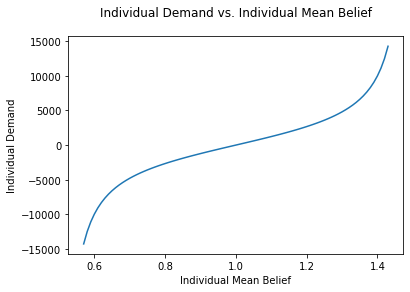

In [18]:
demand_given_pi, arr_mu, arr_demand = demand(1, plot=True)

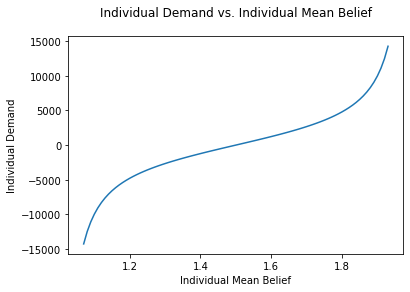

In [602]:
demand_given_pi, arr_mu, arr_demand = demand(1.5, plot=True)

In [20]:
'''
We observe that the two components of the demand curve resemble exponential functions.
'''
initial_guesses = ([100, -7.9, 1, -200], [-10, -5, 5, 0])

def exp_curve(x, a, b, c, d):
    return a * np.exp(b * (x - c)) + d

In [21]:
def best_fit_demand(pi, idx = range(7, 94)):
    '''
    Plot individual demand vs. individual mean belief and find the best fit (sigmoid) curve.
    '''
    demand_given_pi, arr_mu, arr_demand = demand(pi, idx, plot=False)

    # Find best fit exponential curve
    
    fig_ctr = 0
    
    for xrange in [(0, len(arr_mu) // 2), (len(arr_mu) // 2, len(arr_mu))]:
        x = arr_mu[xrange[0]:xrange[1]]
        y = arr_demand[xrange[0]:xrange[1]]
        
        popt, pcov = curve_fit(exp_curve, x, y, initial_guesses[xrange[0] // (len(arr_mu) // 2)])

        a, b, c, d = popt
        
        print(f"Best-Fit Exponential: y = {a:.4f} * exp({b:.4f} * (x - {c:.4f})) + {d:.4f}")
        fig, ax = plt.subplots()
        ax.plot(x, y, label='Individual Demand')
        ax.plot(x, exp_curve(x, *popt), label='Best-Fit Exponential')
        ax.set_title(f"Individual Demand vs. Individual Mean Belief", pad=20)
        ax.set_xlabel("Individual Mean Belief")
        ax.set_ylabel("Individual Demand")
        plt.legend()
        print(sum(y)/len(y))
        plt.savefig(f'fig_demand_vs_mean_belief_{fig_ctr}.pdf', bbox_inches="tight")
        plt.show()
        fig_ctr += 1

Best-Fit Exponential: y = -224.5957 * exp(-8.0500 * (x - 1.0722)) + -301.5529
-4028.572144454184


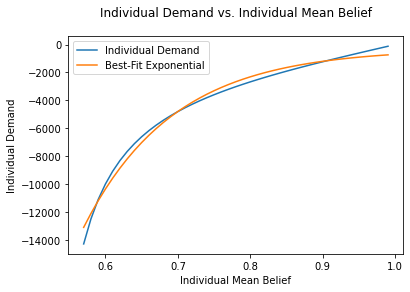

Best-Fit Exponential: y = 206.7570 * exp(7.8723 * (x - 0.9054)) + 198.7987
3937.0137548075395


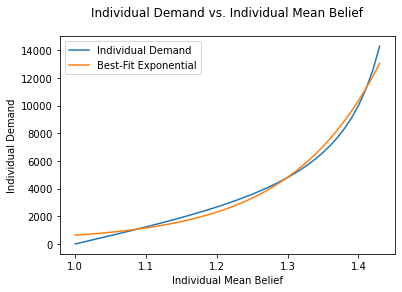

In [22]:
best_fit_demand(1)

# Equilibrium Prices

In [29]:
# Set constant for number of individuals
N = 2500

In [25]:
def sample_population(flag_distribution, *params):
    '''
    Parameters
    ----------
    flag_distribution: A flag that indicates the distribution of the individual mean beliefs over the population.
    params: Parameters of the corresponding distribution.
    
    Return
    ----------
    Sample of distribution of size N
    Name of distribution
    '''
    
    if flag_distribution == "uniform":
        '''
        params = (a, b)
        a: Lower bound of Uniform distribution
        b: Upper bound of Uniform distribution
        '''
        a, b = params
        return np.random.uniform(a, b, N), f"Unif({a}, {b})"
    elif flag_distribution == "normal":
        '''
        params = (mu, sigma)
        mu = mean of Normal distribution
        sigma: standard deviation of Normal distribution
        '''
        mu, sigma = params
        return np.random.normal(mu, sigma, N), f"N({mu}, {sigma}^2)"
    elif flag_distribution == "lognormal":
        '''
        params = (mu, sigma)
        mu = mean of LogNormal distribution
        sigma: standard deviation of LogNormal distribution
        '''
        mu, sigma = params
        return np.random.lognormal(mu, sigma, N), f"LogNormal({mu}, {sigma}^2)"

In [26]:
def price_bounds_to_test_for_equilibrium(flag_distribution, *params):
    '''
    Parameters
    ----------
    flag_distribution: A flag that indicates the distribution of the individual mean beliefs over the population.
    params: Parameters of the corresponding distribution.
    
    Returns
    ----------
    p_min: The minimum price to be considered for the population mean belief.
    p_max: The maximum price to be considered for the population mean belief.
    '''
    if flag_distribution == "uniform":
        '''
        params = (a, b)
        a: Lower bound of uniform distribution
        b: Upper bound of distribution
        '''
        a, b = params
        return a, b
    elif flag_distribution == "normal":
        '''
        params = (mu, sigma)
        mu = mean of Normal distribution
        sigma: standard deviation of Normal distribution
        '''
        mu, sigma = params
        return mu - sigma, mu + sigma
    elif flag_distribution == "lognormal":
        '''
        params = (mu, sigma)
        mu = mean of LogNormal distribution
        sigma: standard deviation of LogNormal distribution
        '''
        mu, sigma = params
        mean = exp(mu + sigma ** 2 / 2)
        stdev = sqrt(exp(sigma ** 2) - 1) * exp(2 * mu + sigma ** 2)
        return mean - stdev, mean + stdev 

In [27]:
def params_for_distribution(flag_distribution, *params):
    '''
    Parameters
    ----------
    flag_distribution: A flag that indicates the distribution of the individual mean beliefs over the population.
    params: Parameters of the corresponding distribution.
    
    Returns
    ----------
    Corresponding parameters for the given distribution.
    Corresponding information to print on the given distribution.
    '''
    if flag_distribution == "uniform":
        '''
        params = (a, b)
        a: Lower bound of uniform distribution
        b: Upper bound of distribution
        '''
        mu, width = params
        return mu - width / 2, mu + width / 2, "width", width
    elif flag_distribution == "normal":
        '''
        params = (mu, sigma)
        mu = mean of Normal distribution
        sigma: standard deviation of Normal distribution
        '''
        mu, sigma = params
        return mu, sigma, "sigma", sigma
    elif flag_distribution == "lognormal":
        '''
        params = (mu, sigma)
        mu = mean of LogNormal distribution
        sigma: standard deviation of LogNormal distribution
        '''
        mu, sigma = params
        return mu, sigma, "sigma", sigma

In [45]:
def equilibrium_price(flag_distribution, *params, idx = range(7, 94), mpv=0.01, plot=False):
    '''
    Parameters
    ----------
    flag_distribution: A flag that indicates the distribution of the individual mean beliefs over the population.
    params: Parameters of the corresponding distribution.
    '''
    mu_population, distribution_string = sample_population(flag_distribution, *params)
    pi_min, pi_max = price_bounds_to_test_for_equilibrium(flag_distribution, *params)

    mean_belief = sum(mu_population) / N
    equilibrium_price = 0
    min_abs_demand = float('inf')
    total_demand_vs_pi = []
    
    for pi in np.arange(pi_min, pi_max + mpv, mpv):  
        demand_given_pi = demand(pi, idx)[0]

        total_demand = 0
        for mu in mu_population:
            total_demand += demand_given_pi[round(100 * mu)]
    
        total_demand_vs_pi.append(total_demand)
        if abs(total_demand) < min_abs_demand:
            min_abs_demand = abs(total_demand)
            equilibrium_price = pi
    
    if plot:
        print(f"Mean belief: {mean_belief:.2f}")
        print(f"Equilibrium price: {equilibrium_price:.2f}")
        fig, ax = plt.subplots()
        ax.plot(np.arange(pi_min, pi_max + mpv, mpv), total_demand_vs_pi)
        ax.set_title(f"Total Demand vs. Market Price, {distribution_string}", pad=20)
        ax.set_xlabel("Market Price")
        ax.set_ylabel("Total Demand")
        plt.savefig(f'fig_demand_vs_price_{flag_distribution}_{params[0]}_{params[1]}.pdf', bbox_inches="tight")
        plt.show()
    
    return equilibrium_price, mean_belief

In [46]:
def equilibrium_price_vs_mean_belief(flag_distribution, *params, mu_min=0.35, mu_max=0.65, ):
    '''
    Plot population equilibrium price as a function of the mean belief of the population.
    Find the best fit line for this plot.
    
    Parameters
    ----------
    flag_distribution: A flag that indicates the distribution of the individual mean beliefs over the population.
    params: Parameters of the corresponding distribution.
    '''
    equilibrium_prices = []
    mean_beliefs = []
    for mu in np.arange(mu_min, mu_max + 1):
        params_for_dist = params_for_distribution(flag_distribution, mu, *params)
        dist_info = params_for_dist[2:4]
        equilibrium_pi, mean_belief = equilibrium_price(flag_distribution, *params_for_dist[:2])
        equilibrium_prices.append(equilibrium_pi)
        mean_beliefs.append(mean_belief)
        
    # Determine best fit line
    m, b = np.polyfit(mean_beliefs, equilibrium_prices, 1)
    print(f"Best fit line: y = {m:.5f}x + {b:.5f}")
    
    # Plot relationship    
    fig, ax = plt.subplots()
    ax.plot(mean_beliefs, equilibrium_prices)
    ax.set_title(f"Equilibrium Price vs. Mean Population Belief, {dist_info[0]} = {dist_info[1]:.2f}")
    ax.set_xlabel("Mean Population Belief")
    ax.set_ylabel("Equilibrium Price")
    plt.savefig(f'fig_equil_px_vs_mean_{flag_distribution}_{params[0]}.pdf', bbox_inches="tight")
    plt.show()

## Uniformly Distributed Beliefs Over Population

Mean belief: 0.50
Equilibrium price: 0.50


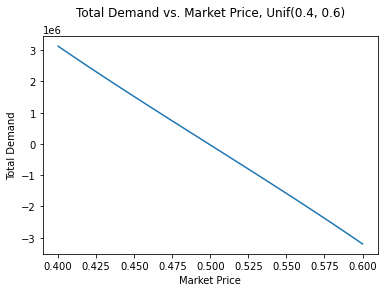

Mean belief: 0.75
Equilibrium price: 0.75


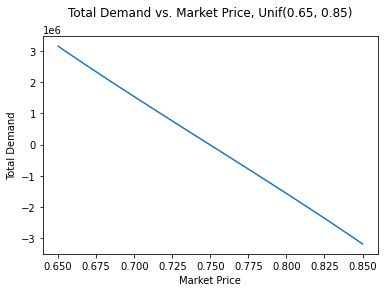

Mean belief: 0.30
Equilibrium price: 0.30


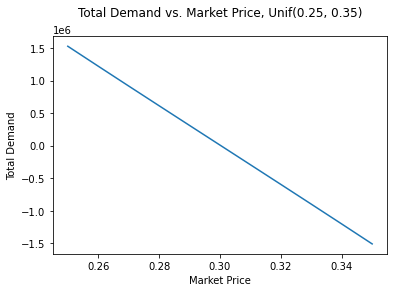

Mean belief: 0.35
Equilibrium price: 0.35


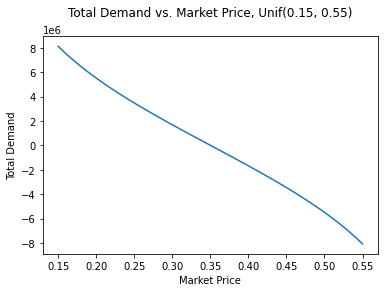

In [32]:
# Examples of the mean population belief and demand curve for various uniform distributions

uniform_distributions = [(0.40, 0.60), (0.65, 0.85), (0.25, 0.35), (0.15, 0.55)]

for (a, b) in uniform_distributions:
    equilibrium_price("uniform", a, b, plot=True)

Best fit line: y = 0.99871x + 0.00095


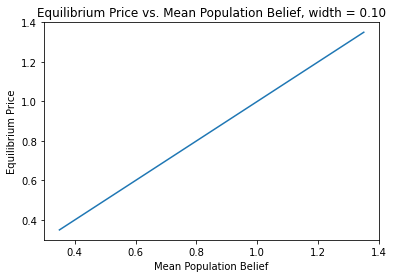

Best fit line: y = 1.00119x + -0.00099


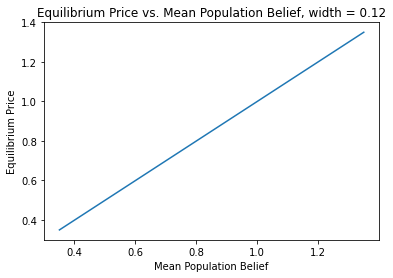

In [38]:
for width in [0.10, 0.12]:
    equilibrium_price_vs_mean_belief("uniform", width)

In [ ]:
# show the relation between the precision of the slope and the width? 

## Normally Distributed Beliefs Over Population

Mean belief: 0.50
Equilibrium price: 0.50


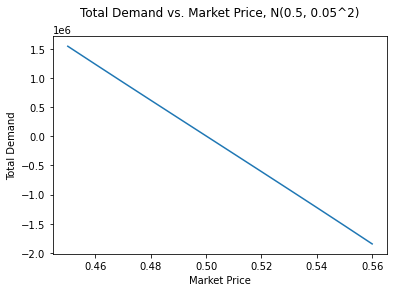

Mean belief: 0.30
Equilibrium price: 0.30


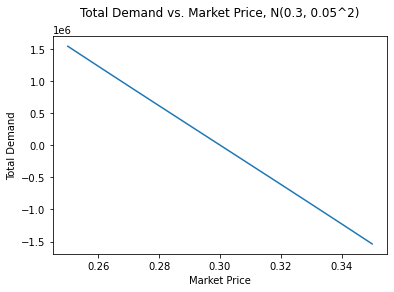

Mean belief: 0.75
Equilibrium price: 0.75


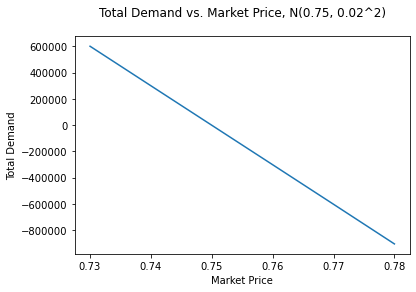

Mean belief: 0.55
Equilibrium price: 0.55


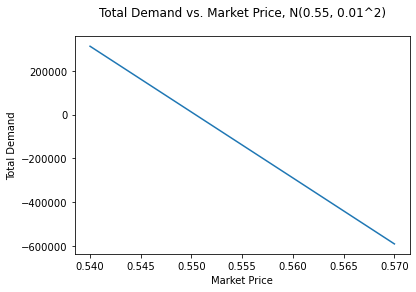

In [33]:
# Examples of the mean population belief and demand curve for various Normal distributions

normal_distributions = [(0.50, 0.05), (0.30, 0.05), (0.75, 0.02), (0.55, 0.01)]

for (mu, sigma) in normal_distributions:
    equilibrium_price("normal", mu, sigma, plot=True)

Best fit line: y = 0.99948x + 0.00057


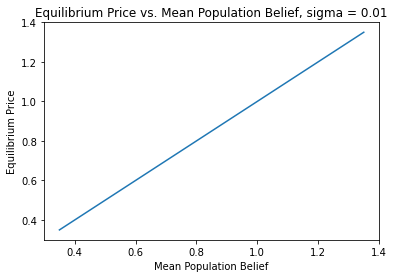

Best fit line: y = 0.99979x + 0.00032


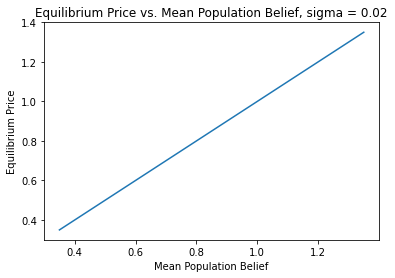

Best fit line: y = 0.99957x + -0.00025


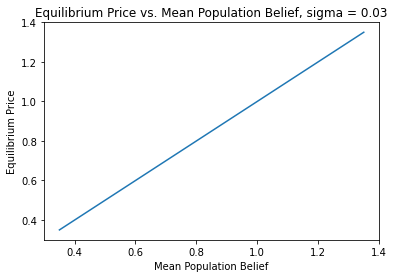

Best fit line: y = 0.99876x + 0.00064


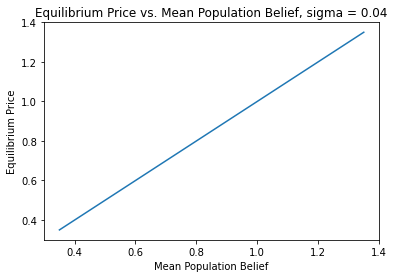

Best fit line: y = 1.00070x + -0.00027


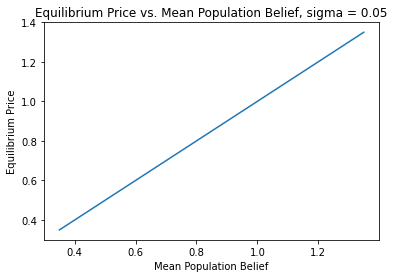

Best fit line: y = 0.99970x + 0.00048


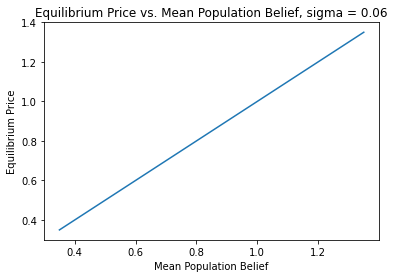

Best fit line: y = 0.99850x + 0.00188


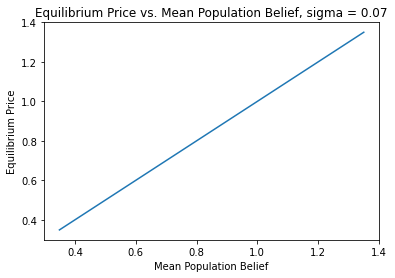

Best fit line: y = 1.00024x + 0.00158


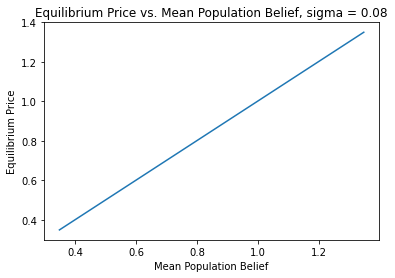

In [39]:
for sigma in np.arange(0.01, 0.08, 0.01):
    equilibrium_price_vs_mean_belief("normal", sigma)

## LogNormally Distributed Beliefs Over Population

Mean belief: 1.01
Equilibrium price: 1.01


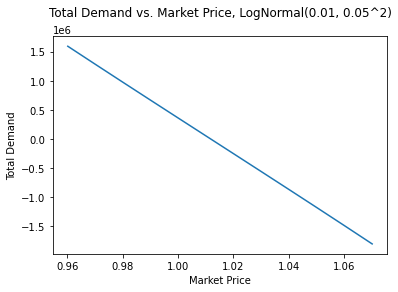

Mean belief: 1.05
Equilibrium price: 1.05


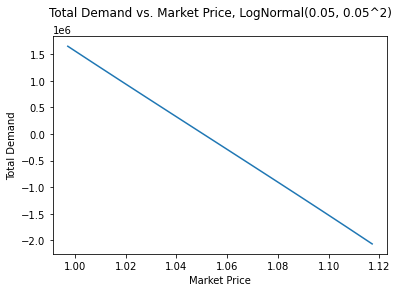

Mean belief: 1.16
Equilibrium price: 1.16


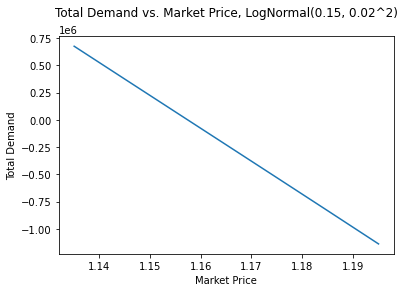

Mean belief: 1.28
Equilibrium price: 1.28


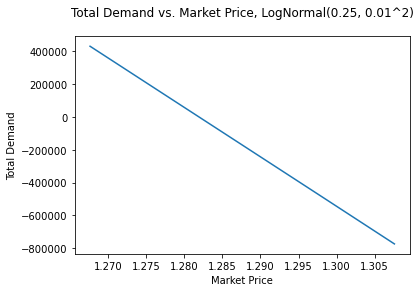

In [34]:
# Examples of the mean population belief and demand curve for various LogNormal distributions

lognormal_distributions = [(0.01, 0.05), (0.05, 0.05), (0.15, 0.02), (0.25, 0.01)]

for (mu, sigma) in lognormal_distributions:
    equilibrium_price("lognormal", mu, sigma, plot=True)

Best fit line: y = 1.00229x + -0.00318


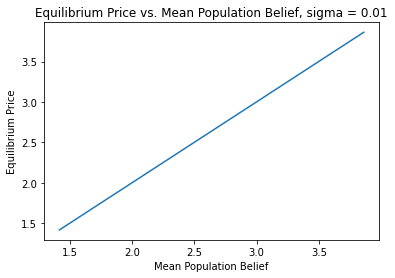

Best fit line: y = 1.00071x + -0.00130


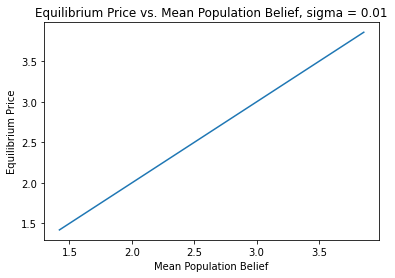

In [44]:
for sigma in [0.005, 0.01]:
    equilibrium_price_vs_mean_belief("lognormal", sigma)